## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file

import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Import the environment file

from TCGame_Env1 import TicTacToe
env = TicTacToe()

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 

def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action] = 0

In [6]:
# Let's check the initial default board position

print(env.state)
print(Q_state(env.state))

[nan, nan, nan, nan, nan, nan, nan, nan, nan]
x-x-x-x-x-x-x-x-x


In [7]:
# Valid actions that agent can take

print(valid_actions(env.state))

[(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (1, 1), (1, 3), (1, 5), (1, 7), (1, 9), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (3, 1), (3, 3), (3, 5), (3, 7), (3, 9), (4, 1), (4, 3), (4, 5), (4, 7), (4, 9), (5, 1), (5, 3), (5, 5), (5, 7), (5, 9), (6, 1), (6, 3), (6, 5), (6, 7), (6, 9), (7, 1), (7, 3), (7, 5), (7, 7), (7, 9), (8, 1), (8, 3), (8, 5), (8, 7), (8, 9)]


#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [8]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
    if(z > epsilon):
        state1 = Q_state(state)
        action = max(Q_dict[state1], key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        agent_actions = env.action_space(state)[0]
        action = random.choice(list(agent_actions))         #Exploration: randomly choosing an action
    return action


#### Tracking the state-action pairs for checking convergence - write your code here

In [9]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
rewards_tracked =  {(2,1):0, (5,5):0, (8,3): 0, (9,7):0}

In [10]:
# Initialise states to be tracked

def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x', (6,5)),
                     ('x-x-x-x-x-x-x-x-x', (1,9)),
                     ('x-3-x-x-1-x-x-x-x', (7,5)),
                     ('x-5-x-x-x-x-5-7-x', (8,2))]        # Select some sample q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
  

In [11]:
# Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [12]:
# This function will append latest Q-values of the 4 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [13]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [14]:
# Defining parameters for the experiment

EPISODES = 5000000
LR = 0.01
GAMMA = 0.90

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.000001

threshold = 2000
policy_threshold = 30000

### Q-update loop ---write your code here

In [15]:
# Q-Dict update 

start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()
    initial_state = env.state
    curr_state = env.state
    is_terminated = False
    add_to_dict(curr_state)
    total_reward = 0

    while(is_terminated != True):
        curr_state_temp = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        reward, next_state, is_terminated = env.step(curr_state, curr_action)
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)

        if(is_terminated != True):
            max_next = max(Q_dict[next_state_temp], key=Q_dict[next_state_temp].get)
            Q_dict[curr_state_temp][curr_action] = Q_dict[curr_state_temp][curr_action] + LR*((reward + GAMMA*(Q_dict[next_state_temp][max_next])) - Q_dict[curr_state_temp][curr_action])
        else:
            Q_dict[curr_state_temp][curr_action] = Q_dict[curr_state_temp][curr_action] + LR*(reward - Q_dict[curr_state_temp][curr_action])

        curr_state = next_state
        total_reward = total_reward + reward

    
    # Tracking Rewards
    if(Q_state(initial_state) in rewards_tracked):
        rewards_tracked[initial_state].append(total_reward)
    
    # every 2000th episode
    if(((episode+1) % threshold) == 0):
        save_obj(rewards_tracked, 'Rewards')
    
    
    # Tracking Q-values
    # at the 1999th episode
    if(episode == threshold-1):
        initialise_tracking_states()

    # every 2000th episode
    if(((episode+1) % threshold) == 0):
        save_tracking_states()
        save_obj(States_track, 'States_tracked')
    
    # Saving Policy
    # every 30000th episodes, the Q-dict will be saved
    if(((episode+1) % policy_threshold) == 0):
        save_obj(Q_dict, 'Policy')


elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print(elapsed_time)

3457.857847929001


#### Check the Q-dictionary

In [16]:
# Checking the Qvalue dictionary

Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.3581612191549144,
              (0, 3): -1.3396914238511974,
              (0, 5): -1.3147471960996204,
              (0, 7): -1.29447818652367,
              (0, 9): -0.6667240183540067,
              (1, 1): -1.2292302446702426,
              (1, 3): -1.2739580275930222,
              (1, 5): -1.3414963705609424,
              (1, 7): -1.2896817400480574,
              (1, 9): -1.3184521498510988,
              (2, 1): -1.3245879452242906,
              (2, 3): -1.13897919012362,
              (2, 5): -1.3202968026650148,
              (2, 7): -1.1470438304950008,
              (2, 9): -0.8280950686061904,
              (3, 1): -1.3506914358381732,
              (3, 3): -1.280920615793695,
              (3, 5): -1.2160291792670244,
              (3, 7): -1.253811564196535,
              (3, 9): 1.3144727723122918,
              (4, 1): -1.3549732691287668,
              (4, 3): -1.3730475632830108,
              (4, 5): 

In [17]:
# Checking the length of Q_dict

len(Q_dict)

2271189

In [18]:
# Checking the rewards 

print('Total Reward = {}'.format(total_reward))
print('Rewards tracked: \n{}'.format(rewards_tracked))

Total Reward = 8
Rewards tracked: 
{(2, 1): 0, (5, 5): 0, (8, 3): 0, (9, 7): 0}


In [19]:
#Let's check the States tracked

States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(6, 5): [-0.33771795901601626,
               -0.6033221935779748,
               -0.7372874127497715,
               -0.8442202507132881,
               -0.902867370309951,
               -0.9316722755352883,
               -0.9533625977000073,
               -0.9717840886529704,
               -0.982049446724955,
               -0.9879915868082944,
               -0.9921265731663943,
               -0.9951884131277832,
               -0.9968767863146212,
               -0.9977583741781747,
               -0.9986840831912479,
               -0.9990743213540725,
               -0.9994169857138948,
               -0.9996290947730118,
               -0.9997778440864658,
               -0.999852870128168,
               -0.9999109855348846,
               -0.9999498042810959,
               -0.9999683855500489,
               -0.9999804847117343,
               -0.9999873325750934,
               -0.999991440253014,
               -0.99

#### Try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

In [20]:
# Let's load the policy as Q-value dictionary

with open('Policy.pkl', 'rb') as handle:
    Q_dict_pkl = pickle.load(handle)

In [21]:
# Before the game starts, initial state would be all null
# Agent starts the game and take the best action with max q-value - (6,1) - value 1 at position 6th
# Env takes the current state and action taken by agent and evaluate - reward, next_state, termination flag
# Env takes the action as - (7,6) 
# so the next state after both agent and env have taken action - [nan, nan, nan, nan, nan, nan, 1, 6, nan]
# Reward = -1 (since this is just a step neither win nor loss nor tie)
# Termination flag = False since the game is not terminated

state = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
action_with_Qval = max(Q_dict_pkl[Q_state(state)], key=Q_dict_pkl[Q_state(state)].get)
print("action with max q-value: {}".format(action_with_Qval))

reward, next_state, isTerminated = env.step(state, action_with_Qval)
print("reward: {}".format(reward))
print("next state after both agent and environment have taken action: {}".format(next_state))
print("is game terminated: {}".format(isTerminated))

action with max q-value: (6, 1)
reward: -1
next state after both agent and environment have taken action: [nan, nan, nan, nan, nan, nan, 1, 6, nan]
is game terminated: False


In [22]:
# State after env action now become the current state
# Agent takes the best action with max q-value - (3,9) - value 9 at position 3rd
# Env takes the current state and action taken by agent and evaluate - reward, next_state, termination flag
# Env takes the action as - (2,2) 
# so the next state after both agent and env have taken action - [nan, nan, 2, 9, nan, nan, 1, 6, nan]
# Reward = -1 (since this is just a step neither win nor loss nor tie)
# Termination flag = False since the game is not terminated

state = next_state
action_with_Qval = max(Q_dict_pkl[Q_state(state)], key=Q_dict_pkl[Q_state(state)].get)
print("action with max q-value: {}".format(action_with_Qval))

reward, next_state, isTerminated = env.step(state, action_with_Qval)
print("reward: {}".format(reward))
print("next state after both agent and environment have taken action: {}".format(next_state))
print("is game terminated: {}".format(isTerminated))

action with max q-value: (3, 9)
reward: -1
next state after both agent and environment have taken action: [nan, nan, 2, 9, nan, nan, 1, 6, nan]
is game terminated: False


In [23]:
# State after env action now become the current state
# Agent takes the best action with max q-value - (0,5) - value 5 at position 0th
# As soon as agent placed value 5 at position 0 - sum of 1st column witnessed a winning combination = 15
# Env will not be able to take any action since the game is terminated 
# Termination flag = True
# Reward = 10 since the agent won the game

state = next_state
action_with_Qval = max(Q_dict_pkl[Q_state(state)], key=Q_dict_pkl[Q_state(state)].get)
print("action with max q-value: {}".format(action_with_Qval))

reward, next_state, isTerminated = env.step(state, action_with_Qval)
print("reward: {}".format(reward))
print("next state after both agent and environment have taken action: {}".format(next_state))
print("is game terminated: {}".format(isTerminated))

action with max q-value: (0, 5)
reward: 10
next state after both agent and environment have taken action: [5, nan, 2, 9, nan, nan, 1, 6, nan]
is game terminated: True


#### Check the states tracked for Q-values convergence
(non-evaluative)

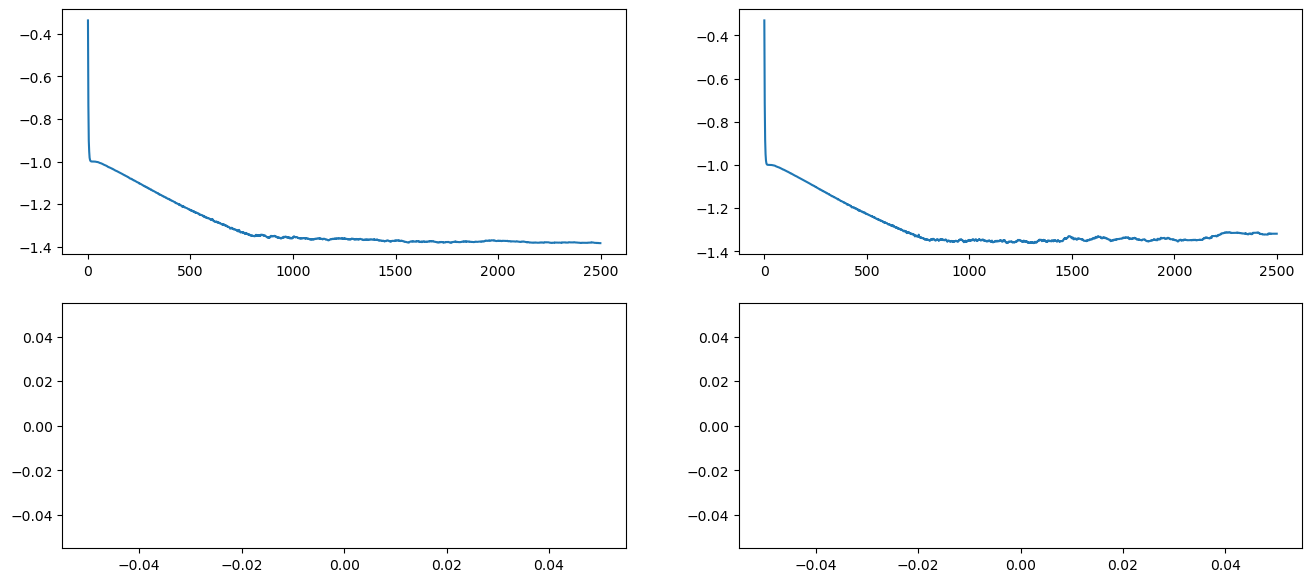

In [24]:
# Write the code for plotting the graphs for state-action pairs tracked

plt.figure(0, figsize=(16,7))

plt.subplot(2,2,1)
x = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
y = np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])
plt.plot(x, y)

plt.subplot(2,2,2)
x = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
y = np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])
plt.plot(x, y)

plt.subplot(2,2,3)
x = np.asarray(range(0, len(States_track['x-3-x-x-1-x-x-x-x'][(7,5)])))
y = np.asarray(States_track['x-3-x-x-1-x-x-x-x'][(7,5)])
plt.plot(x, y)

plt.subplot(2,2,4)
x = np.asarray(range(0, len(States_track['x-5-x-x-x-x-5-7-x'][(8,2)])))
y = np.asarray(States_track['x-5-x-x-x-x-5-7-x'][(8,2)])
plt.plot(x, y)


plt.show()

### Epsilon - decay check

In [25]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

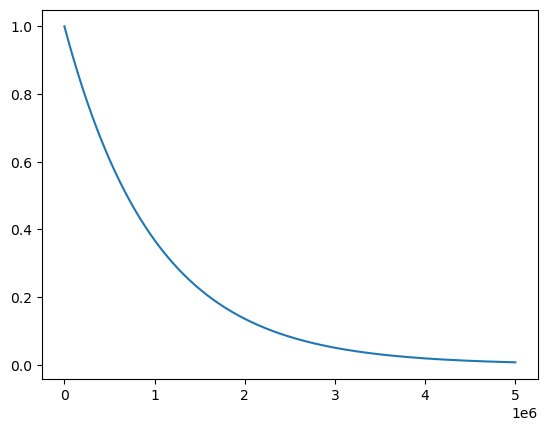

In [26]:
plt.plot(time, epsilon)
plt.show()